# Optical Character Recognition

![A robot reading a newspaper](./images/ocr.jpg)

A common computer vision challenge is to detect and interpret text in an image. This kind of processing is often referred to as *optical character recognition* (OCR).

## Use the Computer Vision Service to Read Text in an Image

The **Computer Vision** cognitive service provides support for OCR tasks, including:

- An **OCR** API that you can use to read text in multiple languages. This API can be used synchronously, and works well when you need to detect and read a small amount of text in an image.
- A **Read** API that is optimized for larger documents. This API is used asynchronously, and can be used for both printed and handwritten text.

You can use this service by creating either a **Computer Vision** resource or a **Cognitive Services** resource.

If you haven't already done so, create a **Cognitive Services** resource in your Azure subscription.

> **Note**: If you already have a Cognitive Services resource, just open its **Quick start** page in the Azure portal and copy its key and endpoint to the cell below. Otherwise, follow the steps below to create one.

1. In another browser tab, open the Azure portal at https://portal.azure.com, and sign in with your Microsoft account.

2. Click the **&#65291;Create a resource** button, search for *Cognitive Services*, and create a **Cognitive Services** resource with the following settings:
    - **Subscription**: *Your Azure subscription*.
    - **Resource group**: *Select or create a resource group with a unique name*.
    - **Region**: *Choose any available region*:
    - **Name**: *Enter a unique name*.
    - **Pricing tier**: S0
    - **I confirm I have read and understood the notices**: Selected.
3. Wait for deployment to complete. Then go to your cognitive services resource, and on the **Overview** page, click the link to manage the keys for the service. You will need the endpoint and keys to connect to your cognitive services resource from client applications.

### Get the Key and Endpoint for your Cognitive Services resource

To use your cognitive services resource, client applications need its  endpoint and authentication key:

1. In the Azure portal, on the **Keys and Endpoint** page for your cognitive service resource, copy the **Key1** for your resource and paste it in the code below, replacing **YOUR_COG_KEY**.
2. Copy the **endpoint** for your resource and and paste it in the code below, replacing **YOUR_COG_ENDPOINT**.
3. Run the code in the cell below by clicking the **Run cell** (&#9655;) button (to the left of the cell).

In [1]:
cog_key = '2c12ab54af524b968519333205c34b44'
cog_endpoint = 'https://vishal-cognitive-services.cognitiveservices.azure.com/'

print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))

Ready to use cognitive services at https://vishal-cognitive-services.cognitiveservices.azure.com/ using key 2c12ab54af524b968519333205c34b44


Now that you've set up the key and endpoint, you can use your computer vision service resource to extract text from an image.

Let's start with the **OCR** API, which enables you to synchronously analyze an image and read any text it contains. In this case, you have an adventising image for the fictional Northwind Traders retail company that includes some text. Run the cell below to read it.. 

Northwind Traders
Fresh produce,
friendly service
Open 7 days a week


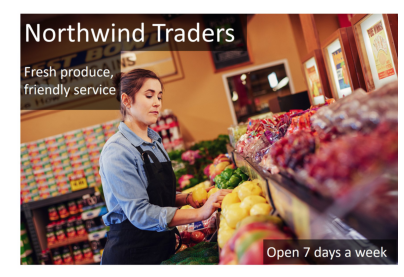

In [2]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
%matplotlib inline

# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Read the image file
image_path = os.path.join('data', 'ocr', 'advert.jpg')
image_stream = open(image_path, "rb")

# Use the Computer Vision service to find text in the image
read_results = computervision_client.recognize_printed_text_in_stream(image_stream)

# Process the text line by line
for region in read_results.regions:
    for line in region.lines:

        # Read the words in the line of text
        line_text = ''
        for word in line.words:
            line_text += word.text + ' '
        print(line_text.rstrip())

# Open image to display it.
fig = plt.figure(figsize=(7, 7))
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
plt.axis('off')
plt.imshow(img)

The text found in the image is organized into a hierarchical structure of regions, lines, and words, and the code reads these to retrieve the results.

In the results, view the text that was read above the image. 

## Display bounding boxes

The results also include *bounding box* coordinates for the lines of text and individual words found in the image. Run the cell below to see the bounding boxes for the lines of text in the advertising image you retrieved above.

Northwind Traders
Fresh produce,
friendly service
Open 7 days a week


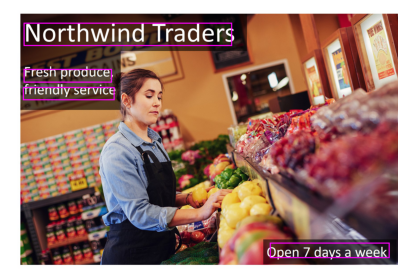

In [3]:
# Open image to display it.
fig = plt.figure(figsize=(7, 7))
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

# Process the text line by line
for region in read_results.regions:
    for line in region.lines:

        # Show the position of the line of text
        l,t,w,h = list(map(int, line.bounding_box.split(',')))
        draw.rectangle(((l,t), (l+w, t+h)), outline='magenta', width=5)

        # Read the words in the line of text
        line_text = ''
        for word in line.words:
            line_text += word.text + ' '
        print(line_text.rstrip())

# Show the image with the text locations highlighted
plt.axis('off')
plt.imshow(img)

In the result, the bounding box for each line of text is shown as a rectangle on the image.

## Use the Read API

The OCR API you used previously works well for images with a small amount of text. When you need to read larger bodies of text, such as scanned documents, you can use the **Read** API. This requires a multi-step process:

1. Submit an image to the Computer Vision service to be read and analyzed asynchronously.
2. Wait for the analysis operation to complete.
3. Retrieve the results of the analysis.

Run the following cell to use this process to read the text in a scanned letter to the manager of a Northwind Traders store.

January 23rd 2020
For the attention of:
The manager
Northwind Traders
123 Any Street
Bellevue, WA
Dear Sir or Madam,
I am writing to thank you for the fantastic service I received at
your store on January 20th. The store assistant who helped me was
extremely pleasant and attentive; and took the time to find all of
the fresh produce I needed.
I've always found the quality of the produce in your store to be
high, and the prices to be competitive; and the helpfulness of your
employees is another reason I will continue to remain a loyal
Northwind Traders customer.
Sincerely,
A customer
A. Customer




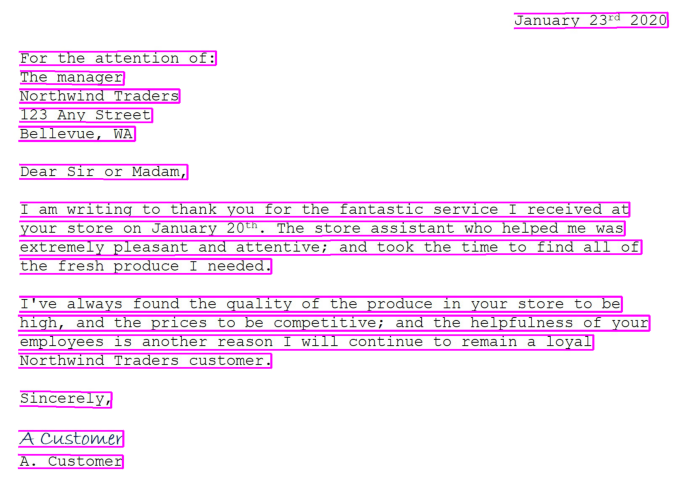

In [5]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
%matplotlib inline


# Read the image file
image_path = os.path.join('data', 'ocr', 'letter.jpg')
image_stream = open(image_path, "rb")

fig = plt.figure(figsize=(12,12))
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Submit a request to read printed text in the image and get the operation ID
read_operation = computervision_client.read_in_stream(image_stream,
                                                      raw=True)
operation_location = read_operation.headers["Operation-Location"]
operation_id = operation_location.split("/")[-1]

# Wait for the asynchronous operation to complete
while True:
    read_results = computervision_client.get_read_result(operation_id)
    if read_results.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# If the operation was successfuly, process the text line by line
if read_results.status == OperationStatusCodes.succeeded:
    for result in read_results.analyze_result.read_results:
        for line in result.lines:
            print(line.text)
            # Show the position of the line of text
            # print(line.bounding_box)
            points = line.bounding_box
            draw.line(points, fill='magenta', width=5)
            # l,t,w = line.bounding_box[0:3]
            # h = line.bounding_box[5]-line.bounding_box[1]
            # draw.rectangle(((l,t), (l+w, t+h)), outline='magenta', width=5)
            

# Open image and display it.
print('\n')
plt.axis('off')
plt.imshow(img)

Review the results. There's a full transcription of the letter, which consists mostly of printed text with a handwritten signature. The original image of the letter is shown beneath the OCR results (you may need to scroll to see it).

## Read handwritten text

In the previous example, the request to analyze the image specified a text recognition mode that optimized the operation for *printed* text. Note that despite this, the handwritten signature was read.

This ability to read handwritten text is extremely useful. For example, suppose you've written a note containing a shopping list, and want to use an app on your phone to read the note and transcribe the text it contains.

Run the cell below to see an example of a read operation for a handwritten shopping list.

Shopping List
Non-Fat milk
Bread
Eggs




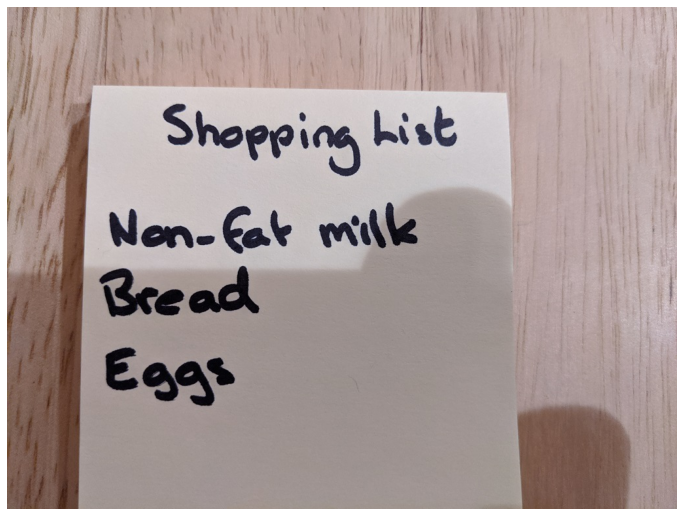

In [6]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
%matplotlib inline

# Read the image file
image_path = os.path.join('data', 'ocr', 'note.jpg')
image_stream = open(image_path, "rb")

# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Submit a request to read printed text in the image and get the operation ID
read_operation = computervision_client.read_in_stream(image_stream,
                                                      raw=True)
operation_location = read_operation.headers["Operation-Location"]
operation_id = operation_location.split("/")[-1]

# Wait for the asynchronous operation to complete
while True:
    read_results = computervision_client.get_read_result(operation_id)
    if read_results.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# If the operation was successfuly, process the text line by line
if read_results.status == OperationStatusCodes.succeeded:
    for result in read_results.analyze_result.read_results:
        for line in result.lines:
            print(line.text)

# Open image and display it.
print('\n')
fig = plt.figure(figsize=(12,12))
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

## More Information

For more information about using the Computer Vision service for OCR, see [the Computer Vision documentation](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-recognizing-text)